In [ ]:
!pip install torch torchvision matplotlib wandb pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import wandb

In [3]:
DATA_DIR = '/content/drive/MyDrive/Ayna/dataset'  # Update as needed!
TRAIN_DIR = os.path.join(DATA_DIR, "training")
VAL_DIR = os.path.join(DATA_DIR, "validation")

assert os.path.exists(os.path.join(TRAIN_DIR, "data.json")), "Training JSON not found"
assert os.path.exists(os.path.join(VAL_DIR, "data.json")), "Validation JSON not found"
print("Training and validation folders and JSON found!")


Training and validation folders and JSON found!


In [4]:
def get_color_list(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return sorted(list(set(d['colour'] for d in data)))

train_json = os.path.join(TRAIN_DIR, "data.json")
color_list = get_color_list(train_json)
color2idx = {c: i for i, c in enumerate(color_list)}
n_colors = len(color_list)

def color_to_onehot(color):
    v = np.zeros(n_colors, dtype=np.float32)
    v[color2idx[color]] = 1.0
    return v

print("Colors:", color_list)


Colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']


In [5]:
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, image_dir="inputs", label_dir="outputs", json_file="data.json", img_size=128):
        with open(os.path.join(root_dir, json_file), 'r') as f:
            self.data = json.load(f)
        self.image_dir = os.path.join(root_dir, image_dir)
        self.label_dir = os.path.join(root_dir, label_dir)
        self.img_size = img_size
        self.transforms = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(os.path.join(self.image_dir, item['input_polygon'])).convert('RGB')
        img = self.transforms(img)  # [3,H,W], float32 0..1

        col = item['colour']
        col_onehot = torch.tensor(color_to_onehot(col), dtype=torch.float32)  # [n_colors]

        label = Image.open(os.path.join(self.label_dir, item['output_image'])).convert('RGB')
        label = self.transforms(label)  # [3,H,W], float32 0..1

        return (img, col_onehot), label


In [6]:
BATCH_SIZE = 32

train_ds = PolygonColorDataset(TRAIN_DIR)
val_ds = PolygonColorDataset(VAL_DIR)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [7]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels, n_colors, out_channels=3, init_channels=32):
        super().__init__()
        self.in_channels = in_channels
        self.n_colors = n_colors

        self.input_conv = UNetBlock(in_channels + n_colors, init_channels)
        self.down1 = UNetBlock(init_channels, init_channels * 2)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = UNetBlock(init_channels * 2, init_channels * 4)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = UNetBlock(init_channels * 4, init_channels * 8)

        self.up2 = nn.ConvTranspose2d(init_channels * 8, init_channels * 4, 2, stride=2)
        self.up_conv2 = UNetBlock(init_channels * 8, init_channels * 4)
        self.up1 = nn.ConvTranspose2d(init_channels * 4, init_channels * 2, 2, stride=2)
        self.up_conv1 = UNetBlock(init_channels * 4, init_channels * 2)
        self.final_conv = nn.Conv2d(init_channels * 2, out_channels, 1)

    def forward(self, img, color_onehot):
        b, c, h, w = img.size()
        # Condition: concatenate color vector as extra channels (broadcast)
        color_map = color_onehot.view(b, self.n_colors, 1, 1).expand(-1, -1, h, w)
        x = torch.cat([img, color_map], dim=1)

        enc1 = self.input_conv(x)
        enc2 = self.down1(enc1)
        enc3 = self.pool1(enc2)
        enc4 = self.down2(enc3)
        enc5 = self.pool2(enc4)

        middle = self.middle(enc5)

        dec2 = self.up2(middle)
        dec2 = torch.cat((dec2, enc4), 1)
        dec2 = self.up_conv2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc2), 1)
        dec1 = self.up_conv1(dec1)
        out = self.final_conv(dec1)
        return torch.sigmoid(out)  # [B,3,H,W]


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, n_colors=n_colors, out_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

wandb.init(project="polygon-unet", name="from_scratch_fixed")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aayushsingh8217 (aayushsingh8217-indian-institute-of-information-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
EPOCHS = 200
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for (imgs, cols), targs in train_loader:
        imgs, cols, targs = imgs.to(device), cols.to(device), targs.to(device)
        out = model(imgs, cols)
        loss = loss_fn(out, targs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (imgs, cols), targs in val_loader:
            imgs, cols, targs = imgs.to(device), cols.to(device), targs.to(device)
            out = model(imgs, cols)
            val_loss += loss_fn(out, targs).item()
    val_loss = val_loss / len(val_loader)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'epoch': epoch+1})
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), 'unet_model.pth')


Epoch 1 | Train Loss: 0.2695 | Val Loss: 0.2511
Epoch 2 | Train Loss: 0.2237 | Val Loss: 0.2458
Epoch 3 | Train Loss: 0.1979 | Val Loss: 0.2416
Epoch 4 | Train Loss: 0.1833 | Val Loss: 0.2374
Epoch 5 | Train Loss: 0.1752 | Val Loss: 0.2320
Epoch 6 | Train Loss: 0.1650 | Val Loss: 0.2257
Epoch 7 | Train Loss: 0.1571 | Val Loss: 0.2205
Epoch 8 | Train Loss: 0.1547 | Val Loss: 0.2119
Epoch 9 | Train Loss: 0.1440 | Val Loss: 0.2023
Epoch 10 | Train Loss: 0.1409 | Val Loss: 0.2223
Epoch 11 | Train Loss: 0.1335 | Val Loss: 0.2220
Epoch 12 | Train Loss: 0.1307 | Val Loss: 0.2123
Epoch 13 | Train Loss: 0.1234 | Val Loss: 0.2090
Epoch 14 | Train Loss: 0.1179 | Val Loss: 0.1968
Epoch 15 | Train Loss: 0.1139 | Val Loss: 0.1943
Epoch 16 | Train Loss: 0.1104 | Val Loss: 0.1392
Epoch 17 | Train Loss: 0.1086 | Val Loss: 0.1089
Epoch 18 | Train Loss: 0.1031 | Val Loss: 0.1005
Epoch 19 | Train Loss: 0.0971 | Val Loss: 0.0949
Epoch 20 | Train Loss: 0.0946 | Val Loss: 0.0941
Epoch 21 | Train Loss: 0.0898

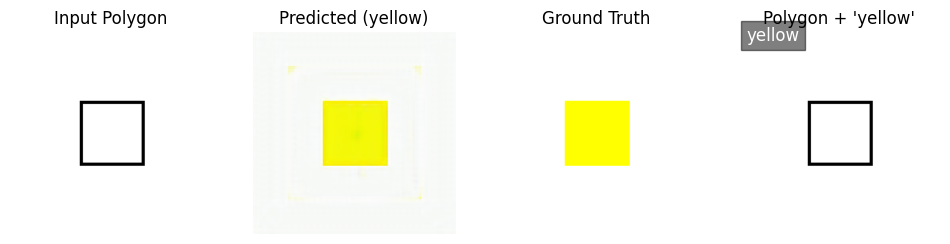

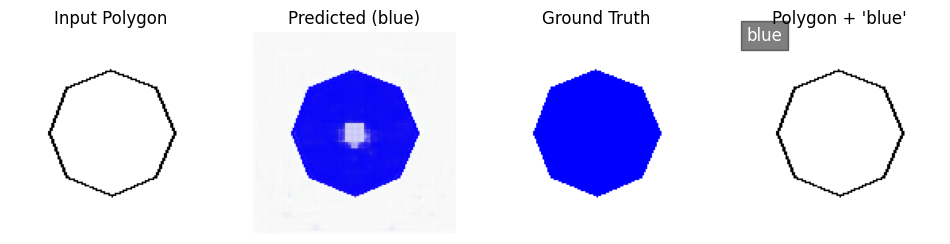

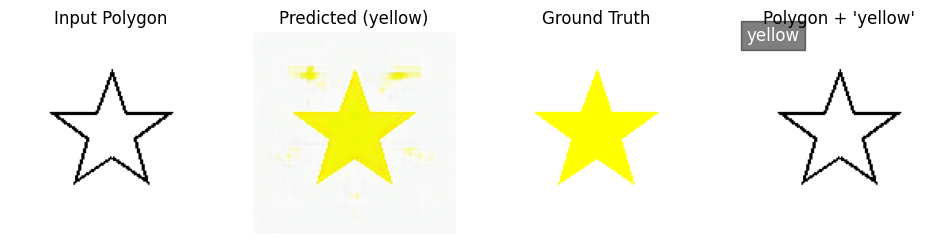

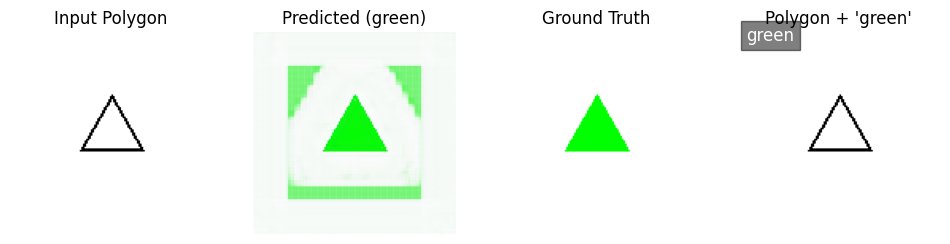

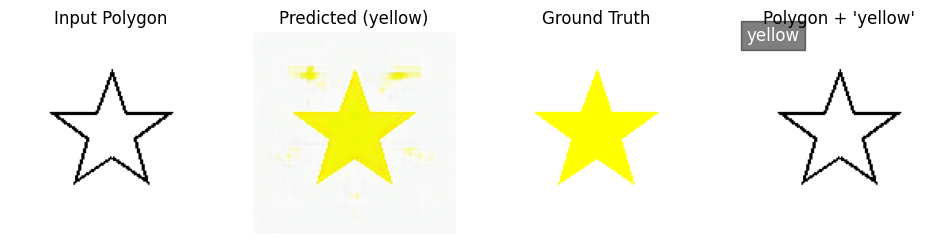

In [10]:
model.eval()
import random

def show_imgs(img, color_idx, pred, gt):
    f, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(img.permute(1,2,0).cpu().numpy())
    axs[0].set_title("Input Polygon")
    axs[0].axis("off")
    axs[1].imshow(pred.permute(1,2,0).detach().cpu().numpy())
    axs[1].set_title(f"Predicted ({color_list[color_idx]})")
    axs[1].axis("off")
    axs[2].imshow(gt.permute(1,2,0).cpu().numpy())
    axs[2].set_title("Ground Truth")
    axs[2].axis("off")
    axs[3].imshow(img.permute(1,2,0).cpu().numpy())
    axs[3].text(5, 5, color_list[color_idx], color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    axs[3].set_title(f"Polygon + '{color_list[color_idx]}'")
    axs[3].axis("off")
    plt.show()

for _ in range(5):
    idx = random.randint(0, len(val_ds)-1)
    (img, color_onehot), gt = val_ds[idx]
    inp = img.unsqueeze(0).to(device)
    col = color_onehot.unsqueeze(0).to(device)
    pred = model(inp, col)[0].detach().cpu()
    color_idx = torch.argmax(color_onehot).item()
    show_imgs(img, color_idx, pred, gt)
